In [1]:
#export
"""
I have several machine learning tools running on my own cluster that's hosted
on https://mlexps.com/#kapi, and this module contains functions, classes and
clis that will contact that service. This is so that if I want to use a language
model in multiple notebooks, I'd have to load the model into my GPU for each
notebook, which would waste a lot of resources. I can't run a lot of notebooks
at the same time as I'd just run out of VRAM. So, by having dedicated services/demos,
I can really focus on serving things well and make it performant. For example::

    "some text"           | kapi.embed()    # returns embedding numpy array
    "What is Python? "    | kapi.complete() # returns string, completes the sentence
    "image.png" | toImg() | kapi.ocr()      # returns `Ocr` object, with bounding boxes and text content of all possible texts
    "cute anime girl"     | kapi.txt2im()   # generates an image from some description
    "image.png" | toImg() | caption()       # generates a caption of an image


"""
__all__ = ["status", "segment", "demo", "embed", "embeds", "complete", "ocr", "txt2im", "caption", "speech", "summarize", "post"]
from k1lib.cli.init import BaseCli; import k1lib.cli.init as init
import k1lib.cli as cli, k1lib, base64, html, json
requests = k1lib.dep("requests"); k1 = k1lib

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#export
settings = k1lib.settings.cli

In [3]:
cli.init.patchNumpy()

In [4]:
#export
s = k1lib.Settings(); settings.add("kapi", s, "cli.kapi settings")
s.add("local", False, "whether to use local url instead of remote url. This only has relevance to me though, as the services are running on localhost")
def get(idx:str, json):
    """Sends a request to any service/demo on https://mlexps.com.
Example::

    # returns "13.0"
    kapi.get("demos/1-arith", {"a": 1, "b": 3, "c": True, "d": 2.5, "e": 10})

:param idx: index of the service, like "kapi/1-embed" """
    url = "http://localhost:9000" if s.local else "https://local.mlexps.com"
    res = requests.post(f"{url}/routeServer/{idx.replace('/', '_')}", json=json).json()
    if not res["success"]: raise Exception(res["reason"])
    return res["data"]
def jsF_get(idx, dataIdx):
    url = "https://local.mlexps.com"
    return f"""await (await fetch("{url}/routeServer/{idx.replace('/', '_')}", {{method: "POST", headers: {{ "Content-Type": "application/json" }}, body: JSON.stringify({dataIdx})}})).json()"""

In [5]:
#export
def status():
    """Displays a table of whether the services are online and available or not"""
    ["kapi/1-embed", "kapi/2-complete", "kapi/3-ocr", "kapi/4-txt2im", "kapi/5-caption", "kapi/6-speech"] | cli.apply(lambda x: [x, requests.get(f"https://local.mlexps.com/routeServer/{x.replace(*'/_')}/healthCheck").text == "ok"]) | cli.insert(["Service", "Online"]) | cli.display(None)

In [6]:
#export
class segment(BaseCli):
    def __init__(self, limit:int=2000):
        """Segments the input string by sentences, such that each segment's length is lower than the specified limit.
Example::

    # returns ['some. Really', 'Long. String', 'Just. Monika']
    "some. Really. Long. String. Just. Monika" | segment(15)

So, this will split the input string by ". ", then incrementally joins the strings together into segments.
This is useful in breaking up text so that it fits within language model's context size"""
        self.limit = limit
    def __ror__(self, text):
        if not isinstance(text, str): raise Exception("Input is not a string!")
        data = [[]]; c = 0; limit = self.limit
        for line in text.split(". "):
            if c + len(line) > limit and c > 0: # if even a single sentence is too big, then just have a segment as that sentence, and don't push it to the next one
                data.append([]); c = 0
            data[-1].append(line); c += len(line)+2
        return data | cli.join(". ").all() | cli.deref()

In [7]:
#export
metas = {} # Dict[prefix -> demo meta]
class demo(BaseCli):
    def __init__(self, prefix:str="demos_1-arith"):
        """Sends a request to one of mlexps.com demos.
Example::

    # returns 21.0
    {"a": 3} | kapi.demo("demos/1-arith")

You don't have to specify all params, just the ones you want to deviate from the defaults
"""
        prefix = prefix.replace(*"/_"); self.prefix = prefix
        if prefix not in metas: metas[prefix] = json.loads(requests.get(f"https://mlexps.com/{prefix.replace(*'_/')}/demo_meta.json").text)
    def __ror__(self, d):
        prefix = self.prefix; meta = metas[prefix]; kw = {}
        for arg in meta["args"]:
            a = meta["defaults"][arg]; anno = meta["annos"][arg]
            if anno in ("checkbox", "bytes", "image", "serialized"): a = a
            elif anno == "dropdown": a = a[1][a[0]]
            elif anno == "apiKey": a = k1lib.apiKey if hasattr(k1lib, "apiKey") else a[0]
            else: a = a[0]
            kw[arg] = k1lib.serve.webToPy(a, anno)
        for k, v in d.items(): kw[k] = v
        for k, v in kw.items(): kw[k] = k1lib.serve.pyToWeb(v, meta["annos"][k])
        url = "http://localhost:9003" if k1lib.settings.cli.kapi.local else "https://local.mlexps.com"
        res = requests.post(f"{url}/routeServer/{prefix}", json=kw)
        if not res.ok: raise Exception(res.reason)
        res = res.json()
        if res["success"]: return k1lib.serve.webToPy(res["data"], meta["annos"]["return"])
        else: raise Exception(res["reason"])
    def __repr__(self): return f"<demo prefix='{self.prefix}'>"
    def _repr_html_(self): s = html.escape(f"{self}"); return f"{s}{metas[self.prefix]['mainDoc']}"

In [7]:
#export
class embed(BaseCli):
    def __init__(self):
        """Gets an embedding vector for every sentence piped into this using `all-MiniLM-L6-v2`.
Example::

    # returns (384,)
    "abc" | kapi.embed() | shape()
    # returns (2, 384)
    ["abc", "def"] | kapi.embed().all() | shape()

- VRAM: 440MB
- Throughput: 512/s

See also: :class:`~k1lib.cli.models.embed`"""
        pass
    def __ror__(self, it): return self._all_opt([it]) | cli.item()
    def _all_opt(self, it:list[str]):
        for b in it | cli.batched(1024, True):
            yield from get("kapi/1-embed", {"lines": k1lib.encode(b)}) | cli.aS(k1lib.decode)
class embeds(BaseCli):
    def __init__(self):
        """Breaks up some text and grab the embedding vectors of each segment.
Example::

    "sone long text" | kapi.embeds() # returns list of (segment, numpy vector)

This is just a convenience cli. Internally, this splits the text up using :class:`segment`
and then embeds each segment using :class:`embed`
"""
        pass
    def __ror__(self, it): return self._all_opt([it]) | cli.item()
    def _all_opt(self, it:list[str]): return it | cli.apply(segment(700) | cli.iden() & embed().all() | cli.transpose()) | cli.deref()

In [7]:
%%time
assert "2+3" | embed() | cli.shape() == (384,)
assert range(1000) | cli.apply(str) | embed().all() | cli.shape() == (1000, 384)

CPU times: user 52 ms, sys: 6.12 ms, total: 58.1 ms
Wall time: 2.96 s


In [55]:
#export
class complete(BaseCli):
    def __init__(self, prompt:str=None, maxTokens:int=200):
        """Generates text from predefined prompts using `Llama 2`.
Example::

    # returns string completion
    "What is Python?" | kapi.complete()
    # returns list of string completions
    ["What is Python?", "What is C++?"] | kapi.complete().all()
    # returns list of string completions. The prompts sent to the server are ["<paragraph 1>\\n\\n\\nPlease summarize the above paragraph", ...]
    ["<paragraph 1>", "<paragraph 2>"] | kapi.complete("Please summarize the above paragraph").all()

- VRAM: 22GB
- Throughput: 8/s

:param max_tokens: maximum amount of tokens

See :class:`~k1lib.cli.models.complete`. That one is an older version using Google Flan T5 instead of llama 2"""
        self.prompt = prompt; self.maxTokens = maxTokens
    def __ror__(self, it): return self._all_opt([it]) | cli.item()
    def _all_opt(self, it:list[str]):
        if self.prompt: it = it | cli.apply(lambda x: f"{x}\n\n\n{self.prompt}: ") | cli.deref()
        if not (isinstance(it, (list, tuple)) and isinstance(it[0], str)):
            raise Exception("You might have forgot to use .all(), like ['str1', 'str2'] | kapi.complete().all()")
        it = it | cli.apply(lambda x: [x, self.maxTokens]) | cli.deref()
        return get("kapi/2-complete", {"prompts": json.dumps(it)}) | cli.aS(json.loads)
    def _jsF(self, meta):
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto()
        body = f"{{ prompts: JSON.stringify([{dataIdx}].map((x) => [`${{x}}\\n\\n\\n{self.prompt or ''}`, {cli.kjs.v(self.maxTokens)}])) }}"
        return f"""
const {fIdx} = async ({dataIdx}) => {{
    const res = {jsF_get('kapi/2-complete', body)}
    return res[0]
}}""", fIdx

In [8]:
%%time
"What is Python?" | complete()

CPU times: user 14.1 ms, sys: 1.19 ms, total: 15.3 ms
Wall time: 5.1 s


'\n\nPython is a popular, high-level programming language for general-purpose programming, created in the late 1980s by Guido van Rossum and first released in 1991. Python is known for its simplicity, readability, and ease of use, making it a great language for beginners and experienced programmers alike. Python is often used for web development, scientific computing, machine learning, data analysis, artificial intelligence, and more. It is a versatile language that can be used for a wide range of applications, and its large and active community means there are many resources available for learning and troubleshooting.\n\n\n\n'

In [12]:
%%time
["What is doxycycline?", "What is C++?"] | complete().all()

CPU times: user 14.3 ms, sys: 2.1 ms, total: 16.4 ms
Wall time: 6.01 s


['\nWhat is doxycycline?\nDoxycycline is a prescription antibiotic that belongs to a class of drugs called tetracyclines. It is used to treat bacterial infections, including urinary tract infections, respiratory infections, and sexually transmitted infections. Doxycycline works by interfering with the ability of bacteria to produce proteins that are necessary for their survival and growth. It is available in a variety of forms, including capsules, tablets, and a liquid solution.\nDoxycycline is typically taken orally, once or twice a day, depending on the type of infection being treated. It may take several days to see the full effects of the medication. Doxycycline can cause side effects, including nausea, vomiting, diarrhea, and abdominal pain.',
 '\nC++ is a general-purpose programming language that was developed by Bjarne Stroustrup at Bell Labs in the 1980s. It is a compiled language, which means that it is translated into machine code before it is executed by the computer. C++ is

In [10]:
%%time
["What is Python?", "What is C++?"]*64 | complete().all() | cli.shape()

CPU times: user 16.1 ms, sys: 2.19 ms, total: 18.3 ms
Wall time: 16.4 s


(128, 448)

In [11]:
"What is doxycycline?" | complete()

'\nDoxycycline is a prescription medication that is used to treat bacterial infections. It belongs to a class of drugs called tetracyclines, which work by stopping the growth of bacteria. Doxycycline is used to treat a wide range of bacterial infections, including pneumonia, sinus infections, and urinary tract infections. It is also used to prevent malaria and treat anthrax infections.\nDoxycycline is available in a variety of formulations, including capsules, tablets, and liquid. It is usually taken once or twice a day, depending on the type of infection being treated. Doxycycline is not recommended for use in children under the age of 8, and it is not recommended for pregnant or breastfeeding women unless specifically advised by a healthcare provider.\nCommon side effects of'

In [45]:
#export
tf = k1.dep("torchvision.transforms")
class ocr(BaseCli):
    def __init__(self, paragraph:bool=False, resize=True):
        """Do OCR (optical character recognition) on some image.
Example::

    o = "some_image.png" | toImg() | kapi.ocr() # loads image and do OCR on them
    o.result

That returns something like this::

    [[[686, 718, 4, 12], 'palng', 0.037828799456428475],
     [[53, 89, 9, 29], '150', 0.9862767603969035],
     [[146, 208, 6, 30], '51,340', 0.8688367610346406],
     [[695, 723, 13, 33], '83', 0.9999892947172615],
     [[783, 855, 13, 29], 'UPGRADes', 0.6299456305919845],
     [[783, 855, 47, 61], 'Monkey Ace', 0.7461469463088448],
     [[827, 863, 117, 133], '5350', 0.9847457394951422],
     [[775, 809, 181, 195], '6325', 0.9660267233848572],
     [[827, 863, 181, 195], 's500', 0.24643410742282867],
     [[773, 811, 243, 259], '5800', 0.5125586986541748],
     [[823, 869, 243, 259], '01600', 0.22119118148432848],
     [[775, 809, 303, 321], '5750', 0.7384281754493713],
     [[827, 861, 305, 321], '5850', 0.6789041403197309]]

This is the main way to use this tool. But you might want to have a quick glance
to judge the performance of the OCR, then you can do ``img | kapi.ocr(True)``,
which returns a PIL image with highlighted bounding boxes.

- VRAM: 1GB
- Throughput: depends heavily on image resolution

:param paragraph: whether to try to combine boxes together or not
:param resize: whether to resize the images to a reasonable size before sending it over or not. Runs faster if true"""
        self.paragraph = paragraph; self.resize = resize
    def __ror__(self, it): return self._all_opt([it]) | cli.item()
    def _all_opt(self, it:list["PIL"]):
        def resize(it): # resizing if they're too big
            for img in it:
                w, h = img | cli.shape()
                if w > h:
                    if w > 1000: frac = 1000/w; img = img | tf.Resize([int(h*frac), int(w*frac)])
                else:
                    if h > 1000: frac = 1000/h; img = img | tf.Resize([int(h*frac), int(w*frac)])
                yield img, self.paragraph
        return (resize(it) if self.resize else it | cli.apply(lambda img: [img, self.paragraph])) | cli.batched(10, True)\
            | cli.apply(lambda imgParas: [imgParas, get("kapi/3-ocr", {"data": k1.encode(imgParas | cli.apply(cli.toBytes(), 0) | cli.deref())}) | cli.aS(k1.decode)] | cli.transpose()) | cli.joinSt() | ~cli.apply(Ocr)
class Ocr:
    def __init__(self, imgPara, res):
        """Ocr result object. Stores raw results from model in ``.result`` field and has many more functionalities"""
        self.img, self.para = imgPara; self.res = res
    @property
    def result(self): return self.res
    def __repr__(self): return f"<Ocr shape={self.img | cli.shape()}>"
    def _overlay(self) -> "PIL":
        img = self.img; res = self.res; p5 = k1.p5; w, h = img | cli.shape(); p5.newSketch(*img | cli.shape()); p5.background(255); p5.fill(255, 0)
        res | cli.cut(0) | ~cli.apply(lambda x1,x2,y1,y2: [x1,h-y2,x2-x1,y2-y1]) | ~cli.apply(p5.rect) | cli.deref()
        res | cli.cut(0, 1) | ~cli.apply(lambda x1,x2,y1,y2: [min(x1,x2), h-max(y1,y2)], 0) | ~cli.apply(lambda xy,s: [s,*xy]) | ~cli.apply(p5.text) | cli.deref()
        im2 = p5.img(); alpha = 0.3; return [img, im2] | cli.apply(cli.toTensor() | cli.op()[:3]) | ~cli.aS(lambda x,y: x*alpha+y*(1-alpha)) | cli.op().to(int) | cli.op().permute(1, 2, 0) | cli.toImg()
    def _repr_html_(self): s = html.escape(f"{self}"); return f"<pre>{s}</pre><img src='data:image/jpeg;base64, {base64.b64encode(self._overlay() | cli.toBytes()).decode()}' />"
    def __getstate__(self): d = {**self.__dict__}; d["img"] = self.img | cli.toBytes(); return d # better compression due to converting to jpg
    def __setstate__(self, d): self.__dict__.update(d); self.img = self.img | cli.toImg()

In [10]:
img = "~/Downloads/nice/btd6.png" | cli.toImg()
o = img | ocr(); o.result

[[[771, 813, 5, 17], 'round', 0.7995255977610858],
 [[58, 100, 10, 34], '150', 0.8835281133651733],
 [[166, 234, 8, 34], '51,340', 0.9991667862586479],
 [[782, 814, 14, 38], '83', 0.9999995785315409],
 [[879, 963, 13, 33], 'UPGRADes', 0.762410354371979],
 [[881, 963, 53, 69], 'Monkey Ace', 0.917134012309055],
 [[933, 971, 133, 149], '5350', 0.9002463221549988],
 [[873, 911, 203, 219], '5325', 0.4814128875732422],
 [[931, 971, 203, 219], '5500', 0.765638530254364],
 [[869, 913, 271, 291], 'G800', 0.31971874833106995],
 [[925, 977, 271, 291], '64600', 0.14586368917200013],
 [[871, 911, 341, 361], '5750', 0.5963790416717529],
 [[929, 971, 341, 361], '5850', 0.99748295545578]]

In [11]:
o

<Ocr shape=(1000, 562)>

In [60]:
img = "~/Downloads/nice/btd6.png" | cli.toImg()
o = img | ocr(); o.result

[[[771, 813, 5, 17], 'round', 0.7995255977610858],
 [[58, 100, 10, 34], '150', 0.8835281133651733],
 [[166, 234, 8, 34], '51,340', 0.9991667862586479],
 [[782, 814, 14, 38], '83', 0.9999995785315409],
 [[879, 963, 13, 33], 'UPGRADes', 0.762410354371979],
 [[881, 963, 53, 69], 'Monkey Ace', 0.917134012309055],
 [[933, 971, 133, 149], '5350', 0.9002463221549988],
 [[873, 911, 203, 219], '5325', 0.4814128875732422],
 [[931, 971, 203, 219], '5500', 0.765638530254364],
 [[869, 913, 271, 291], 'G800', 0.31971874833106995],
 [[925, 977, 271, 291], '64600', 0.14586368917200013],
 [[871, 911, 341, 361], '5750', 0.5963790416717529],
 [[929, 971, 341, 361], '5850', 0.99748295545578]]

In [63]:
o

<Ocr shape=(1000, 562)>

In [22]:
#export
class txt2im(BaseCli):
    def __init__(self, num_inference_steps=10):
        """Generates images from text descriptions, using stable diffusion v2.
Example::

    "a bowl of apples" | kapi.txt2im() # returns PIL image

- VRAM: 5.42GB
- Throughput: 1/s
"""
        self.num_inference_steps = num_inference_steps
    def __ror__(self, it): return get("kapi/4-txt2im", {"prompt": it, "num_inference_steps": self.num_inference_steps}) | cli.aS(base64.b64decode) | cli.toImg()

CPU times: user 67.9 ms, sys: 0 ns, total: 67.9 ms
Wall time: 4.07 s


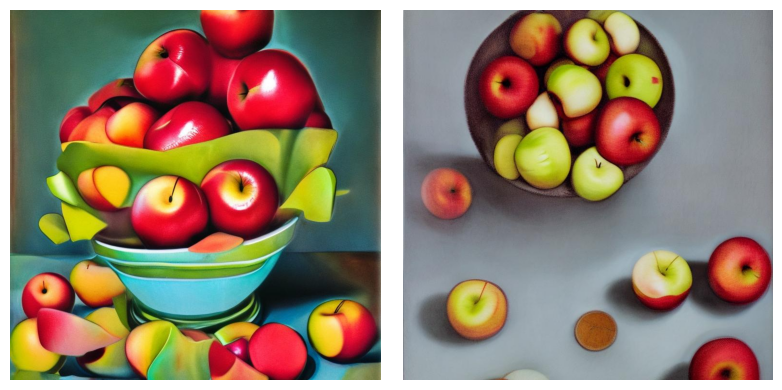

In [32]:
%%time
imgs = ["a bowl of apples"]*2 | txt2im().all() | cli.deref()
imgs | cli.plotImgs(fac=4)

In [37]:
#export
class caption(BaseCli):
    def __init__(self):
        """Captions images using model `Salesforce/blip-image-captioning-large`.
Example::

    img = "some_image.png" | toImg() # loads PIL image
    img | kapi.caption()                  # returns string description

- VRAM: 2.5GB
- Throughput: 16/s
"""
        pass
    def __ror__(self, it): return self._all_opt([it]) | cli.item()
    def _all_opt(self, it:list["PIL"]): return get("kapi/5-caption", {"images": k1lib.encode(it)}) | cli.aS(k1lib.decode)

In [40]:
%%time
imgs | caption().all() | cli.deref()

CPU times: user 36.5 ms, sys: 908 µs, total: 37.4 ms
Wall time: 2.81 s


['painting of a bowl of apples with a green leaf on top',
 'there are apples in a bowl and a penny on the table']

In [42]:
%%time
imgs*16 | caption().all() | cli.deref() | cli.shape()

CPU times: user 38.3 ms, sys: 2.02 ms, total: 40.4 ms
Wall time: 3.49 s


(32, 53)

In [ ]:
#export
class speech(BaseCli):
    def __init__(self, sep=False):
        """Converts English speech to text using whisper-large-v2.
Example::

    "audio.mp3" | toAudio() | kapi.speech() # returns string transcript

- VRAM: 4GB
- Throughput: 20min video finish transcribing in ~25s, so around 60x faster than real time

If the input audio is too long (>25 minutes), then it will be broken up
into multiple smaller pieces around 20 min each and sent to the server,
so at the bounds, it might go wrong a little bit

:param sep: if True, separate transcripts of each segment (returns List[transcript]),
    if False (default), joins segment's transcripts together into a single string"""
        self.sep = sep
    def __ror__(self, audio:"conv.Audio"):
        nSplits = int(audio.raw.duration_seconds/60/25)+1
        res = audio | cli.splitW(*[1]*nSplits) | cli.apply(lambda piece: get("kapi/6-speech", {"audio": base64.b64encode(piece | cli.toBytes()).decode()}))
        return list(res) if self.sep else res | cli.join(". ")

In [ ]:
#export
def _summarize(text:str) -> str:
    return text | segment(2000) | complete("<|end of transcript|>\n\nPlease summarize the above transcript using 1-3 sentences: ").all()\
        | cli.op().strip().all() | cli.deref() | cli.join(". ")
class summarize(BaseCli):
    def __init__(self, length=1000):
        """Summarizes text in multiple stages until it's shorter than ``length`` in
characters or until further compression is not possible. Example::

    url = "https://www.youtube.com/watch?v=NfmSjGbnEWk"
    audio = url   | toAudio()     # downloads audio from youtube
    text  = audio | kapi.speech() # does speech recognition
    text | summarize()            # summarize the text. For a 23 minute video/22k characters text, it should take around 23s to summarize everything

This will return an array of strings::

    [
        "shortened text final stage",
        "shortened text stage 2",
        "shortened text stage 1",
        "original text",
    ]

So in each stage, the original text is split up into multiple pieces, then
each piece is summarized using :class:`complete` and then all summary will
be joined together, creating the "shortened text stage 1". This continues
until it the text's length does not decrease any further, or it's shorter
than the desired length.

:param length: desired summary string length"""
        self.length = length
    def __ror__(self, text:str):
        stages = [text]; l = len(text)
        while True:
            if len(text) < self.length: return stages | cli.reverse() | cli.deref()
            l = len(text); text = _summarize(text); stages.append(text)
            if len(text)/l > 0.8: return stages | cli.reverse() | cli.deref() # if length not shrinking, then just return early

In [97]:
#export
class post(BaseCli):
    def __init__(self, url):
        """Creates a post request from a URL that can be read using :meth:`~k1lib.cli.inp.cat`.
Example::

    # returns str of the results
    {"some": "json data"} | kapi.post("https://some.url/some/path")

Notice how there isn't a get request counterpart, because you can always just cat() them
directly, as get requests don't have a body::

    cat("https://some.url/some/path")
"""
        self.url = url
    def __ror__(self, d): return requests.post(self.url, json=d).text
    def _jsF(self, meta):
        fIdx = init._jsFAuto(); dataIdx = init._jsDAuto()
        return f"""\
const {fIdx} = async ({dataIdx}) => {{
    const res = await fetch({json.dumps(self.url)}, {{ method: "POST", headers: {{ "Content-Type": "application/json" }}, body: JSON.stringify({dataIdx}) }});
    if (res.ok) return await res.text();
    throw new Error(`Can't send POST request to '{self.url}': ${{res.status}} - ${{res.statusText}}`);
}}""", fIdx

In [98]:
assert { "obj": [["edges",{"it":["ab","bc","ca"]}]] } | post("https://local.mlexps.com/routeServer/kapi_10-graphviz") | cli.aS(json.loads) | cli.op()["success"]

# Demos collection

In [8]:
{} | demo("demos/1-arith")

13.0

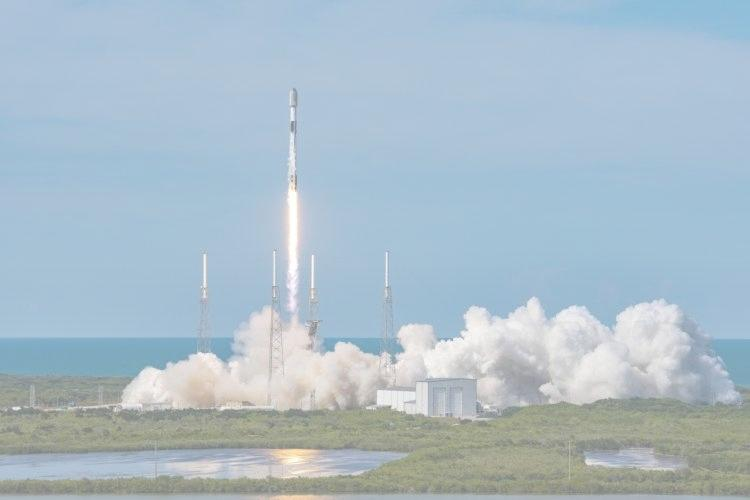

In [9]:
{} | demo("demos/2-whiten")

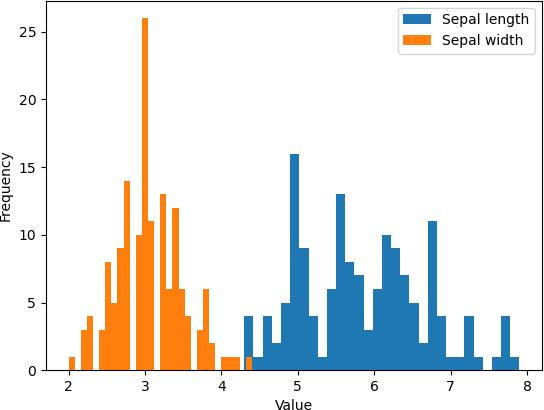

In [10]:
{} | demo("demos/3-csv")

In [11]:
{} | demo("demos/4-file")

b'{"len": 18}'

In [12]:
{} | demo("demos/7-delay")

'ok'

In [16]:
assert {} | demo("demos/8-json") | cli.aS(type) == dict

In [17]:
{} | demo("demos/9-diff-node")

7

In [19]:
assert {"lines": ["abc", "def", "123"]} | demo("kapi/1-embed") | cli.shape() == (3, 384)

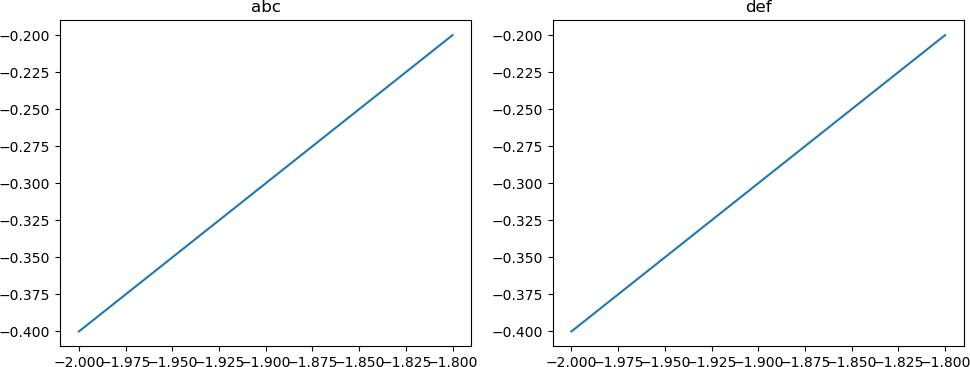

In [20]:
{} | demo("kapi/9-mpl")

In [21]:
{} | demo("kapi/10-graphviz")

'\n<div id="_k1_svg_pre_52_wrapper" style="position: relative"><?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Generated by graphviz version 2.50.0 (0) -->\n<!-- Pages: 1 -->\n<svg width="89pt" height="188pt" viewBox="0.00 0.00 89.00 188.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n<g id="_k1_svg_221" class="graph" transform="scale(1 1) rotate(0) translate(4 184)">\n<polygon fill="white" stroke="transparent" points="-4,4 -4,-184 85,-184 85,4 -4,4"/>\n<!-- _idx_166 -->\n<g id="_idx_166" class="node">\n<title>_idx_166</title>\n<ellipse fill="none" stroke="black" cx="54" cy="-162" rx="27" ry="18"/>\n<text text-anchor="middle" x="54" y="-158.3" font-family="Times,serif" font-size="14.00">a</text>\n</g>\n<!-- _idx_167 -->\n<g id="_idx_167" class="node">\n<title>_idx_167</title>\n<ellipse fill="none" stroke="black" cx="27" cy="-90" rx="27" ry="18"/>\n<text text-anchor="middle" x="27" y="-86.3" font-family="Times,serif" font-size="14.00">b</text>\n</g>\n<!-- _idx_166&#45;&gt;_idx_167 -->\n<g id="_k1_svg_218" class="edge">\n<title>_idx_166&#45;&gt;_idx_167</title>\n<path fill="none" stroke="black" d="M47.6,-144.41C44.49,-136.34 40.67,-126.43 37.17,-117.35"/>\n<polygon fill="black" stroke="black" points="40.4,-116.03 33.54,-107.96 33.87,-118.55 40.4,-116.03"/>\n</g>\n<!-- _idx_168 -->\n<g id="_idx_168" class="node">\n<title>_idx_168</title>\n<ellipse fill="none" stroke="black" cx="54" cy="-18" rx="27" ry="18"/>\n<text text-anchor="middle" x="54" y="-14.3" font-family="Times,serif" font-size="14.00">c</text>\n</g>\n<!-- _idx_167&#45;&gt;_idx_168 -->\n<g id="_k1_svg_219" class="edge">\n<title>_idx_167&#45;&gt;_idx_168</title>\n<path fill="none" stroke="black" d="M33.4,-72.41C36.51,-64.34 40.33,-54.43 43.83,-45.35"/>\n<polygon fill="black" stroke="black" points="47.13,-46.55 47.46,-35.96 40.6,-44.03 47.13,-46.55"/>\n</g>\n<!-- _idx_168&#45;&gt;_idx_166 -->\n<g id="_k1_svg_220" class="edge">\n<title>_idx_168&#45;&gt;_idx_166</title>\n<path fill="none" stroke="black" d="M57.65,-36.09C59.68,-46.43 61.98,-59.91 63,-72 64.34,-87.94 64.34,-92.06 63,-108 62.28,-116.5 60.93,-125.69 59.49,-133.99"/>\n<polygon fill="black" stroke="black" points="56.03,-133.44 57.65,-143.91 62.91,-134.71 56.03,-133.44"/>\n</g>\n</g>\n</svg><div id="_k1_svg_pre_52_popup" style="position: absolute; display: none; background: white; padding: 8px 12px; border-radius: 6px; box-shadow: 0 3px 5px rgb(0 0 0 / 0.3); z-index: 1000000"></div></div>\n<script>\n    const _k1_svg_pre_52_nodeId_node_popup = ([["_idx_166", null], ["_idx_167", null], ["_idx_168", null]]).map(([x,y]) => [x, document.querySelector(`#${x}`), y]);\n    const _k1_svg_pre_52_nodes = _k1_svg_pre_52_nodeId_node_popup.map(([x,n,y]) => n); let _k1_svg_pre_52_activeNode = null;\n    const _k1_svg_pre_52_popup = document.querySelector("#_k1_svg_pre_52_popup"); const _k1_svg_pre_52_wrapper = document.querySelector("#_k1_svg_pre_52_wrapper");\n    const _k1_svg_pre_52_nodeId2popup = {}; for (const [x,n,y] of _k1_svg_pre_52_nodeId_node_popup) { _k1_svg_pre_52_nodeId2popup[x] = y; };\n    let _k1_svg_pre_52_mouseX = 0; let _k1_svg_pre_52_mouseY = 0; _k1_svg_pre_52_wrapper.onmousemove = (e) => { _k1_svg_pre_52_mouseX = e.clientX; _k1_svg_pre_52_mouseY = e.clientY; };\n\n    setInterval(() => {\n        if (_k1_svg_pre_52_activeNode) {\n            const rect = _k1_svg_pre_52_activeNode.getBoundingClientRect();\n            if (!(rect.x <= _k1_svg_pre_52_mouseX && _k1_svg_pre_52_mouseX < rect.x+rect.width && rect.y <= _k1_svg_pre_52_mouseY && _k1_svg_pre_52_mouseY < rect.y+rect.height)) { _k1_svg_pre_52_activeNode = null; _k1_svg_pre_52_popup.innerHTML = ""; _k1_svg_pre_52_popup.style.display = "none"; }\n        }\n\n        if (!_k1_svg_pre_52_activeNode) { // can\'t just do `if (activeNode) ... else ...` btw. Separated out for a reason\n            const wRect = _k

In [22]:
!../../export.py cli/kapi

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-06 07:19:27,159	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.19:6379...
2024-01-06 07:19:27,167	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
----- exportAll
13574   0   60%   
9044    1   40%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.4.5
Uninstalling k1lib-1.4.4.5:
  Successfully uninstalled k1lib-1.4.4.5
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/